In [151]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import great_circle
import geopandas as gp

import os

import mplleaflet

In [135]:
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

In [138]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [28]:
crimes = pd.DataFrame()

mypath = './metropolitan_all'
for (dirpath, dirnames, filenames) in os.walk(mypath):
    if dirpath is not './metropolitan_all':
        for filename in filenames:
            if 'csv' in filename and '2015' in filename:
                frame = pd.read_csv(dirpath + '/' + filename)
                crimes = crimes.append(frame, ignore_index=True)
len(crimes)

631378

In [29]:
crimes = crimes.dropna(axis=0, subset=['LSOA code'])
len(crimes)

623327

In [31]:
locations = pd.DataFrame()
locations = crimes[["LSOA code","Longitude","Latitude"]]
locations = locations.drop_duplicates()
len(locations)

56447

In [32]:
locations_LSOA = locations
locations_LSOA = locations_LSOA.drop_duplicates('LSOA code')
len(locations_LSOA)

5222

In [30]:
crimes = crimes[['Month','LSOA code',"Longitude","Latitude",'Crime type']]

In [ ]:
crimes.iloc[0]

In [33]:
morden_underground = (51.4009669,-0.2012335)

In [7]:
geo = gp.GeoDataFrame().from_file('./LSOA/LSOA_2011_EW_BGC_V2.shp')
len(geo)

34753

In [ ]:
geo.iloc[0]

In [100]:
geo = geo[geo['LSOA11CD'].isin(locations_LSOA['LSOA code'])]

In [101]:
len(geo)

5222

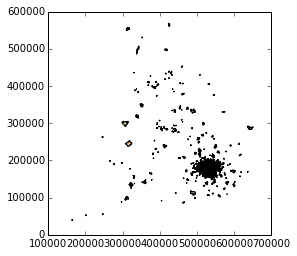

In [102]:
geo.geometry.plot()

In [3]:
london = gp.GeoDataFrame().from_file('./london/london_wards.shp')
len(london)

649

In [11]:
london.iloc[0]

AREA                                                          0
AREA_CODE                                                   LBW
CODE                                                  E05000405
DESCRIPT0                                     CIVIL VOTING AREA
DESCRIPT1                                                  None
DESCRIPTIO                                  London Borough Ward
FILE_NAME                              GREATER_LONDON_AUTHORITY
HECTARES                                                755.173
NAME                                     Chessington South Ward
NUMBER                                                       52
NUMBER0                                                     733
POLYGON_ID                                                50840
TYPE_COD0                                                  None
TYPE_CODE                                                    VA
UNIT_ID                                                   10884
geometry      POLYGON ((-0.3306790212463

In [ ]:
london.geometry.plot()

In [4]:
bds = london.total_bounds
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x10fd37350>)

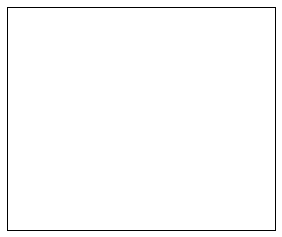

In [15]:
m = Basemap(
    projection='tmerc',
    lon_0=-2.,
    lat_0=49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'london/london_wards',
    'london',
    color='none',
    zorder=2)

In [85]:
temp = [Polygon([m(x,y) for x,y in pol.exterior.coords]) for pol in london.geometry]

In [91]:
# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(crimes['Longitude'], crimes['Latitude'])])
crime_points = MultiPoint(list(map_points.values))
london['basemap_geometry'] = gp.GeoSeries([Polygon([m(x,y) for x,y in pol.exterior.coords]) for pol in london.geometry])
wards_polygon = prep(MultiPolygon(list(london['basemap_geometry'])))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, crime_points)
len(ldn_points)

622738

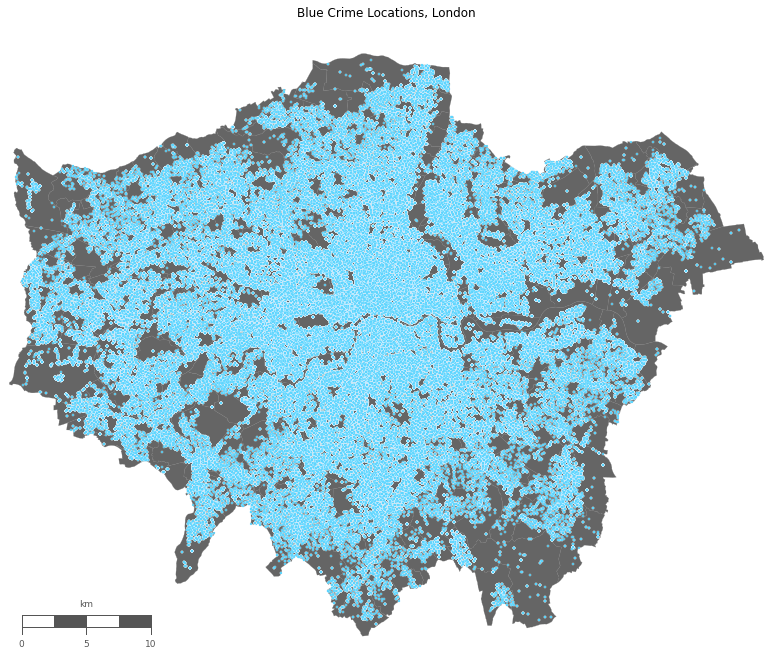

In [94]:
# draw ward patches from polygons
london['patches'] = london['basemap_geometry'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    5, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Blue Crime Locations', zorder=3)
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(london['patches'].values, match_original=True))

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.title("Blue Crime Locations, London")
plt.tight_layout()
# this will set the image width to 722px at 100dpi
fig.set_size_inches(20, 10)
plt.savefig('london_crimes.png', dpi=100, alpha=True)
plt.show()

In [97]:
#TODO more efficient algorithm with erasing the points already assigned to one of the polygons
london['crime_count'] = london['basemap_geometry'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))

AttributeError: 'GeoDataFrame' object has no attribute 'geometry_basemap'

In [117]:
london.drop(['geometry', 'basemap_geometry', 'patches'],axis=1).to_csv('london_wards_crime_count_2015.csv')

In [141]:
london['density_m'] = london['crime_count'] / (gp.GeoSeries(london['basemap_geometry']).area/10**6)
# it's easier to work with NaN values when classifying
london.replace(to_replace={'density_m': {0: np.nan}}, inplace=True)

In [146]:
breaks = nb(
    london[london['density_m'].notnull()].density_m.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=london[london['density_m'].notnull()].index)
london.drop(['jenks_bins'],axis=1,inplace=True)
london = london.join(jb)
london.jenks_bins.fillna(-1, inplace=True)

In [147]:
jenks_labels = ["<= %0.1f/m$^2$(%s wards)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]
jenks_labels.insert(0, 'No crimes (%s wards)' % len(london[london['density_m'].isnull()]))

/Users/adamgolinski/Documents/University/MPhys/mphys/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: sort(....) is deprecated, use sort_index(.....)


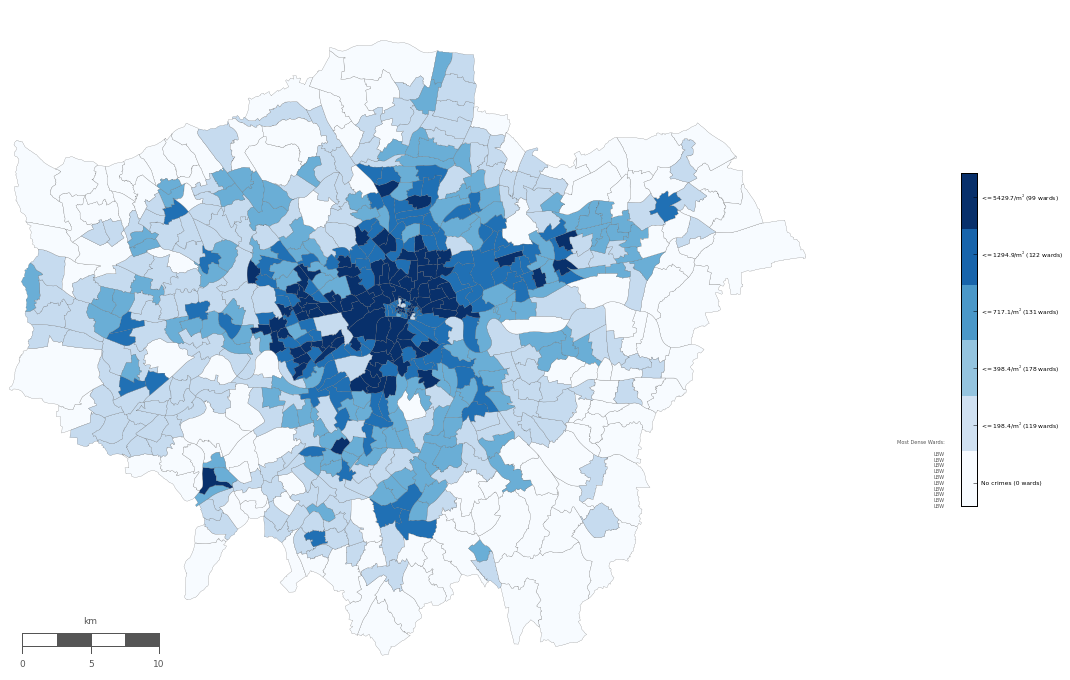

In [149]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
london['patches2'] = london.basemap_geometry.map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(london['patches2'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(london['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=6)

# Show highest densities, in descending order
highest = '\n'.join(
    value[1] for _, value in london[(london['jenks_bins'] == 4)][:10].sort().iterrows())
highest = 'Most Dense Wards:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    -1., 0 - 0.007,
    highest,
    ha='right', va='bottom',
    size=5,
    color='#555555')

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(20, 10)
plt.savefig('london_crimes_density.png', dpi=300, alpha=True)
plt.show()